# Higher order models for anharmonic potential energy surfaces
In this tutorial we study the potential energy surface (PES) for a (110) Cu slab. The atoms at the surface experience a strong anharmonic PES due to the asymmetry in bonds normal to the surface. We test how well 2nd, 3rd and 4th order  models can describe this PES.

We will use the ASE EMT calculator to act as a reference.

In [1]:
# Setup plotting, seaborn is just used to make figures look a bit nicer
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_context('talk')
except ModuleNotFoundError:
    print('Dont worry')

## Constructing a fourth order model

### Relax slab
The first thing we need to do is to relax the slab system. Here we'll use a (4, 4, 8) slab with vacuum in the z-direction.

In [2]:
from ase.build import fcc110
from ase.calculators.emt import EMT
from ase.optimize import BFGS

atoms_ideal = fcc110('Cu', size=(4, 4, 8))
atoms_ideal.center(vacuum=20, axis=2)
atoms_ideal.pbc = True

calc = EMT()
atoms_ideal.set_calculator(calc)

dyn = BFGS(atoms_ideal)
dyn.run(fmax=0.0001, steps=1000)

      Step     Time          Energy          fmax
BFGS:    0 11:28:54       21.887800         0.229063
BFGS:    1 11:28:54       21.862786         0.211822
BFGS:    2 11:28:54       21.738942         0.086855
BFGS:    3 11:28:54       21.733685         0.075338
BFGS:    4 11:28:54       21.702463         0.059071
BFGS:    5 11:28:54       21.679451         0.055757
BFGS:    6 11:28:55       21.666107         0.052096
BFGS:    7 11:28:55       21.661602         0.047481
BFGS:    8 11:28:55       21.658716         0.036174
BFGS:    9 11:28:55       21.655299         0.022583
BFGS:   10 11:28:55       21.653332         0.011247
BFGS:   11 11:28:55       21.652898         0.004553
BFGS:   12 11:28:56       21.652858         0.003086
BFGS:   13 11:28:56       21.652849         0.001936
BFGS:   14 11:28:56       21.652839         0.001263
BFGS:   15 11:28:56       21.652835         0.000409
BFGS:   16 11:28:56       21.652835         0.000076


True

### Generate training structures
For simplicity's sake we'll use the standard rattle method to generate the training structures. Note however that in general this is often not recommended when training higher order models to be used for large displacements (i.e. elevated temperature).

In [3]:
from hiphive.structure_generation import generate_rattled_structures

n_structures = 10
rattle_std = 0.075

In [4]:
structures = generate_rattled_structures(atoms_ideal, n_structures, rattle_std)
for structure in structures:
    structure.set_calculator(calc)
    forces = structure.get_forces()
    displacements = structure.positions - atoms_ideal.get_positions()
    
    structure.new_array('displacements', displacements)
    structure.new_array('forces', forces)
    structure.positions = atoms_ideal.get_positions()


### ClusterSpace and StructureContainer
When constructing a force constant potential it is highly recommended to use cutoff-selection. Here we'll simply use a cutoff of `[5.0, 4.0, 3.5]` which sets the cutoffs for 2nd, 3rd and 4th order respectively.

In [5]:
from hiphive import ClusterSpace, StructureContainer

cs = ClusterSpace(atoms_ideal, [5.0, 4.0, 3.5])
sc = StructureContainer(cs)
for structure in structures:
    sc.add_structure(structure)

Primitive cell:
    Formula: Cu8
    Cell:
        [  0.00000  -2.55266   0.00000]
        [  3.61000   0.00000   0.00000]
        [  0.00000   0.00000  48.93429]
    Basis:
        Cu  [  0.50000   0.50000   0.41019]
        Cu  [  0.00000   0.00000   0.43536]
        Cu  [  0.50000   0.50000   0.46130]
        ...

Crystal symmetry:
    Spacegroup:          Pmmn (59)
    Unique site:         4
    Symmetry operations: 8
    symprec:             1.00e-05

Cutoffs:
    Maximum cutoff: 5.0
    Found 8 center atoms with 80 images totaling 88 atoms

Clusters:
    Clusters: {2: 266, 3: 520, 4: 587}
    Total number of clusters: 1373

Orbits:
    Orbits: {2: 36, 3: 57, 4: 58}
    Total number of orbits: 151

Eigentensors:
    Eigentensors: {2: 197, 3: 764, 4: 1769}
    Total number of parameters: 2730

Constraints:
    Acoustic: True
    Number of degrees of freedom: {2: 185, 3: 543, 4: 765}
    Total number of degrees of freedom: 1493


### Training
The number of degrees of freedom in the cluster space is quite large but manageable. Next we'll train the force constant potential using `RFE` (Recursive Feature Elimination). This may take a minute or two.

To learn more about the available training methods (including RFE) in hiphive see [here](https://hiphive.materialsmodeling.org/moduleref/optimizers.html)


In [6]:
from hiphive import ForceConstantPotential
from trainstation import Optimizer

opt = Optimizer(sc.get_fit_data(), train_size=0.9, fit_method='rfe', step=0.05, cv_splits=2)
opt.train()
fcp = ForceConstantPotential(cs, opt.parameters)
print(opt)

===================== Optimizer ======================
seed                           : 42
fit_method                     : rfe
standardize                    : True
n_target_values                : 3840
n_parameters                   : 1493
n_nonzero_parameters           : 531
parameters_norm                : 225906
target_values_std              : 0.7077869
rmse_train                     : 0.01129448
rmse_test                      : 0.01419279
R2_train                       : 0.9997457
R2_test                        : 0.9995904
AIC                            : -29927.55
BIC                            : -26663.03
train_size                     : 3456
test_size                      : 384
step                           : 0.05
cv_splits                      : 2


We can see that RFE discarded roughly 50% of the parameters. To check the accuracy of the model we plot the target vs predicted forces.

Text(0, 0.5, 'Predicted force (eV/Å)')

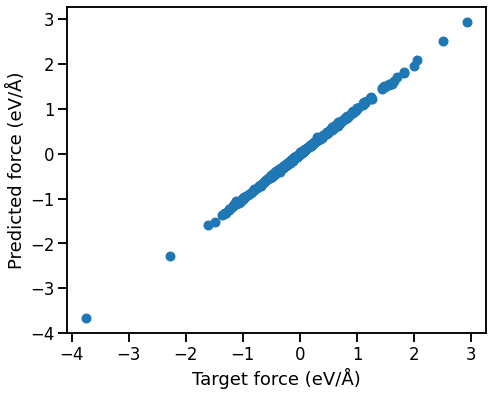

In [7]:
sd = opt.scatter_data_test
plt.figure(figsize=(7.5, 6))
plt.plot(sd.target, sd.predicted, 'o')
plt.xlabel('Target force (eV/Å)')
plt.ylabel('Predicted force (eV/Å)')

The target and predicted forces lies on a straight line which indicate a good fit.

## Calculating the PES
Next we'll test how well the fourth order model can reproduce the anharmonic PES of the surface.
To do this we locate an atom on the top of the surface and compute the potential energy as a function of displacement in the z-direction.

First we do this with the EMT calculator to get a reference PES.

In [8]:
def compute_potential_energy_landscape(atoms_ideal, dz_vals, calc):
    """ Computes PES by displacing an atom on the top of the surface
    according to dz_vals using calc. """
    
    # reference energy
    atoms_ideal.set_calculator(calc)
    E0 = atoms_ideal.get_potential_energy()

    # compute PES
    atom_ind = np.argmax(atoms_ideal.positions[:, 2])
    data = []
    for dz in dz_vals:
        atoms_tmp = atoms_ideal.copy()
        atoms_tmp.set_calculator(calc)
        atoms_tmp[atom_ind].z += dz
        data.append([dz, atoms_tmp.get_potential_energy() - E0])
    return np.array(data)

In [9]:
import numpy as np

dz_vals = np.linspace(-0.6, 0.6, 31)
pes_emt = compute_potential_energy_landscape(atoms_ideal, dz_vals, EMT())

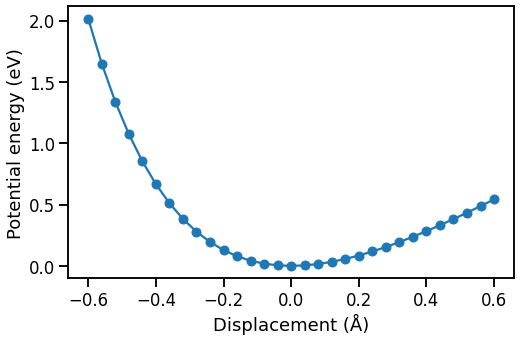

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(pes_emt[:, 0], pes_emt[:, 1], '-o')
plt.xlabel('Displacement (Å)')
plt.ylabel('Potential energy (eV)');

Next we'll use the fourth-order model to compute the PES. To do this we must setup a `ForceConstantCalculator`.

In [11]:
from hiphive.calculators import ForceConstantCalculator

fcs = fcp.get_force_constants(atoms_ideal)
calc_fcp = ForceConstantCalculator(fcs)

In [12]:
pes_fcp4 = compute_potential_energy_landscape(atoms_ideal, dz_vals, calc_fcp)

We'll now compare the obtained PES with the reference (EMT) PES.

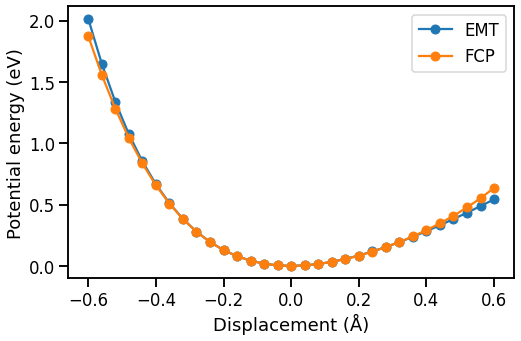

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(pes_emt[:, 0], pes_emt[:, 1], '-o', label='EMT')
plt.plot(pes_fcp4[:, 0], pes_fcp4[:, 1], '-o', label='FCP')
plt.legend()
plt.xlabel('Displacement (Å)')
plt.ylabel('Potential energy (eV)');

Finally we'll see the contribution to the PES from the various orders in the expansion. In order to do this we must setup new ForceConstants objects for each specific order and then create ForceConstantCalculators from those.

In [14]:
from hiphive import ForceConstants

pes_orders = dict()
for order in [2, 3, 4]:
    fc_dict = fcs.get_fc_dict(order=order)
    fcs_order = ForceConstants.from_sparse_dict(fc_dict, atoms_ideal)
    calc_order = ForceConstantCalculator(fcs_order)
    pes = compute_potential_energy_landscape(atoms_ideal, dz_vals, calc_order)
    pes_orders[order] = pes

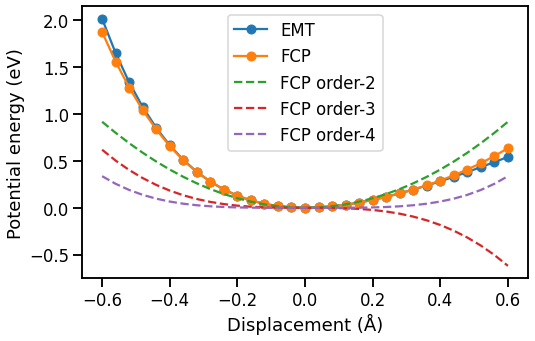

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(pes_emt[:, 0], pes_emt[:, 1], '-o', label='EMT')
plt.plot(pes_fcp4[:, 0], pes_fcp4[:, 1], '-o', label='FCP')

for order, pes in pes_orders.items():
    plt.plot(pes[:, 0], pes[:, 1], '--', label='FCP order-{}'.format(order))
    
plt.legend()
plt.xlabel('Displacement (Å)')
plt.ylabel('Potential energy (eV)');

The fact that FCP PES starts to deviate from the EMT at higher displacement is natrual. Including higher order terms (5, 6, ...) may improve the accuracy of the FCP. Another important aspect to consider is the fact that our FCP is trained from rather small displacements, and hence we can not expected high accuracy for very large displacements.